In [1]:
import pandas as pd
import numpy as np
np.random.seed(1907)

#For classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#For visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#To remove stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

#Remove stopwords for easier parsing afterwards
stop_words = list(stopwords.words("english"))

df = pd.read_csv("../../data/abstract_dataset.csv")
df.head(5)

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,doi,abstract,task
0,nnU-Net: a self-configuring method for deep le...,10.1038/s41592-020-01008-z,biomedical imaging is a driver of scientific d...,Cardiac
1,Automated cardiovascular magnetic resonance im...,10.1186/s12968-018-0471-x,cardiovascular resonance cmr imaging is a stan...,Cardiac
2,Deep Learning for Cardiac Image Segmentation: ...,10.3389/fcvm.2020.00025,deep learning has become the most widely used ...,Cardiac
3,Deep Learning for Segmentation Using an Open L...,10.1109/tmi.2019.2900516,delineation of the cardiac structures from 2d ...,Cardiac
4,Multi-Scale Self-Guided Attention for Medical ...,10.1109/jbhi.2020.2986926,even though convolutional neural networks cnns...,Cardiac


## Data Analysis

### Task representation

<AxesSubplot: xlabel='count', ylabel='task'>

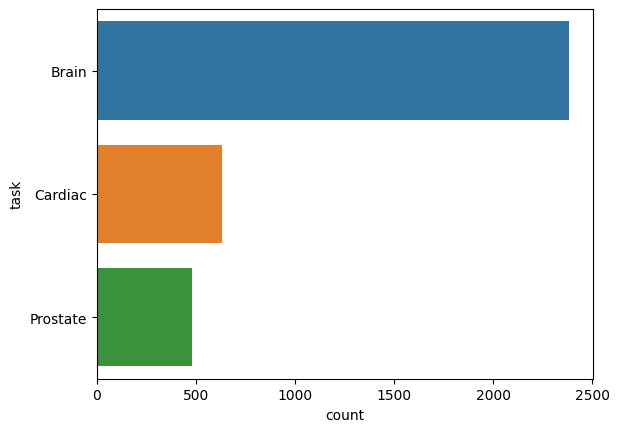

In [2]:
sns.countplot(data=df,y='task',order=df["task"].value_counts().index)

Note: imbalanced class distribution , not a lot of exemples for Prostate class

### Wordcloud per task without tf-idf

Plot of most frequent word in paper abstracts for each task

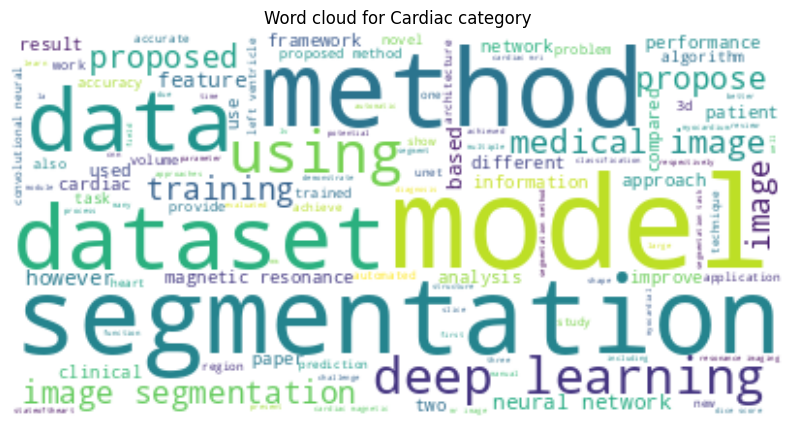

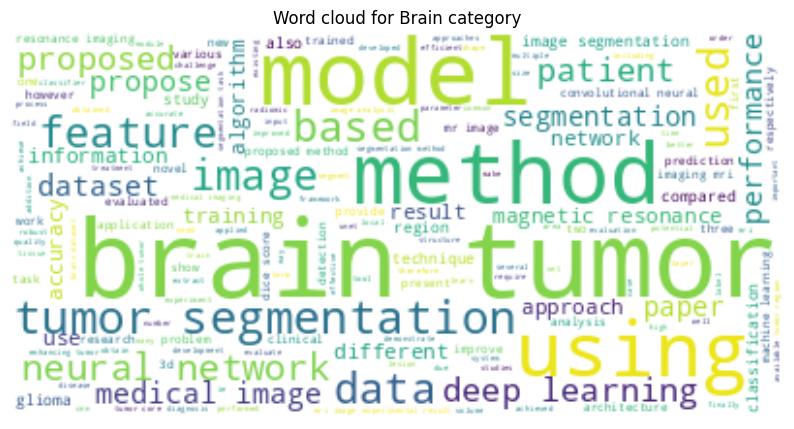

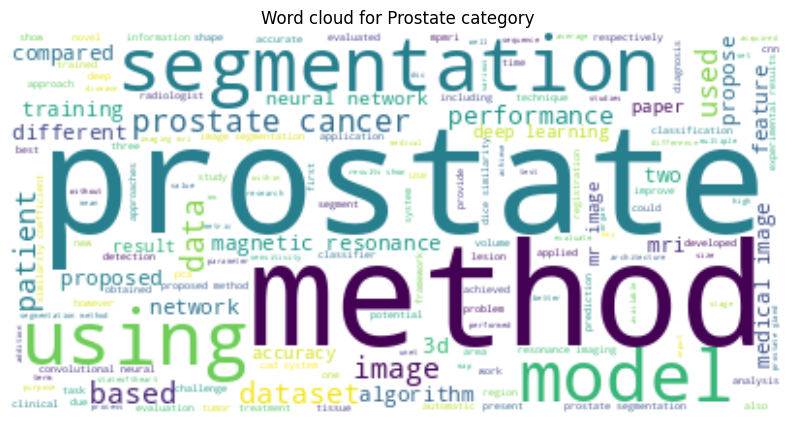

In [3]:
for task in df["task"].unique():
    #Get text of the category
    task_df = df[df["task"]==task]
    text = ' '.join(task_df["abstract"])

    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(text)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Wordcloud per task with tf-idf

Plot of most frequent word in paper abstracts for each task using tf-idf over the whole dataset (not 1 tf-idf per task)

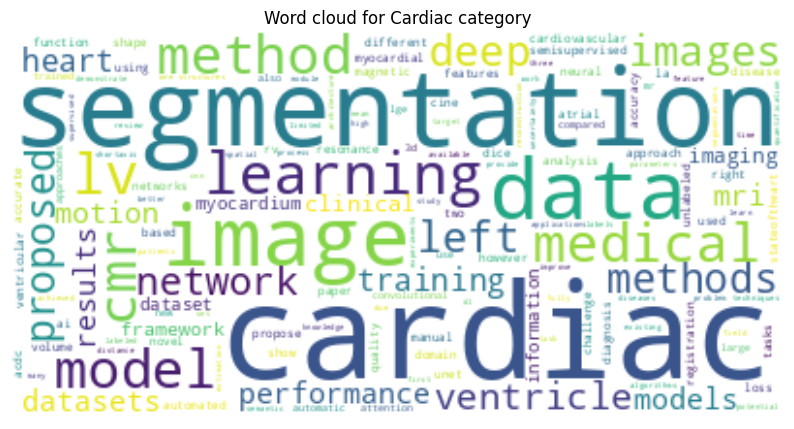

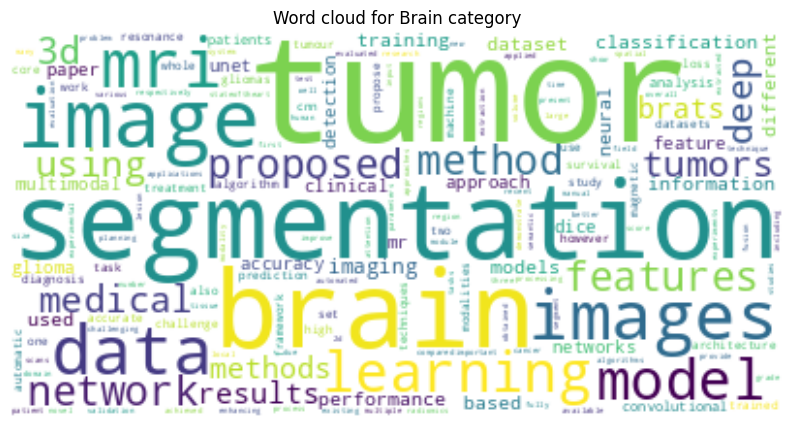

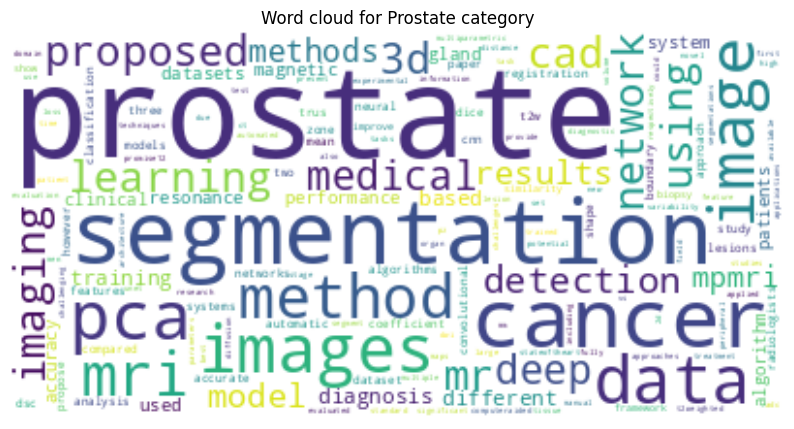

In [4]:
corpus = df["abstract"].to_list()
vectorizer = TfidfVectorizer(stop_words=stop_words)
vecs = vectorizer.fit(corpus)
feature_names = vectorizer.get_feature_names_out()

for task in df["task"].unique():
    #Get text of the category
    task_df = df[df["task"]==task]
    corpus = task_df["abstract"].to_list()
    vecs = vectorizer.transform(corpus)
    dense = vecs.todense()
    lst1 = dense.tolist()
    df_tf_idf = pd.DataFrame(lst1, columns=feature_names)

    x = df_tf_idf.T.sum(axis=1)
    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate_from_frequencies(x)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

## Multi-class Classification with TF-IDF representation and keeping paper with multiple dataset

In [5]:
np.random.seed(1907)

train,test = train_test_split(df,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["abstract"].to_list()
X_dev = dev["abstract"].to_list()
X_test = test["abstract"].to_list()

y_train = train["task"].to_list()
y_dev = dev["task"].to_list()
y_test = test["task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

### List of words selected with TF-IDF

In [6]:
print(vectorizer.get_feature_names_out())

['3d' 'accuracy' 'accurate' 'achieved' 'algorithm' 'algorithms' 'also'
 'analysis' 'approach' 'approaches' 'architecture' 'automated' 'automatic'
 'available' 'based' 'better' 'brain' 'brats' 'cancer' 'cardiac'
 'challenge' 'classification' 'clinical' 'cnn' 'compared' 'convolutional'
 'data' 'dataset' 'datasets' 'deep' 'detection' 'diagnosis' 'dice'
 'different' 'due' 'feature' 'features' 'first' 'framework' 'glioma'
 'high' 'however' 'image' 'images' 'imaging' 'improve' 'information'
 'learning' 'loss' 'magnetic' 'manual' 'medical' 'method' 'methods'
 'modalities' 'model' 'models' 'mr' 'mri' 'multimodal' 'multiple'
 'network' 'networks' 'neural' 'new' 'novel' 'one' 'paper' 'patients'
 'performance' 'prediction' 'propose' 'proposed' 'prostate' 'regions'
 'research' 'resonance' 'respectively' 'results' 'segmentation' 'set'
 'show' 'stateoftheart' 'study' 'task' 'tasks' 'techniques' 'three' 'time'
 'trained' 'training' 'treatment' 'tumor' 'tumors' 'two' 'unet' 'use'
 'used' 'using' 'work

### Error Analysis

Train accuracy: 0.8485714285714285


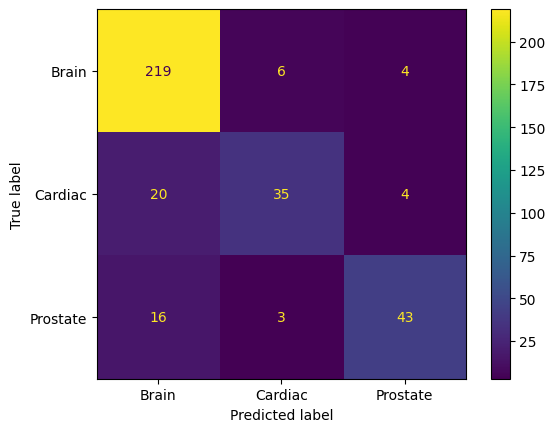

In [7]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

Note: Very good results for Brain class (which is by far the majority class so that may be an explanation). Pretty good ones Prostate but lot of confusion between Cardiac exemples and Brain class.

### Removing papers with multiple datasets

In [8]:
np.random.seed(1907)

df_unique = df.drop_duplicates(subset=['title','doi'],keep=False)

train,test = train_test_split(df_unique,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["abstract"].to_list()
X_dev = dev["abstract"].to_list()
X_test = test["abstract"].to_list()

y_train = train["task"].to_list()
y_dev = dev["task"].to_list()
y_test = test["task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

RandomForestClassifier(n_estimators=200)

Train accuracy: 0.9074626865671642


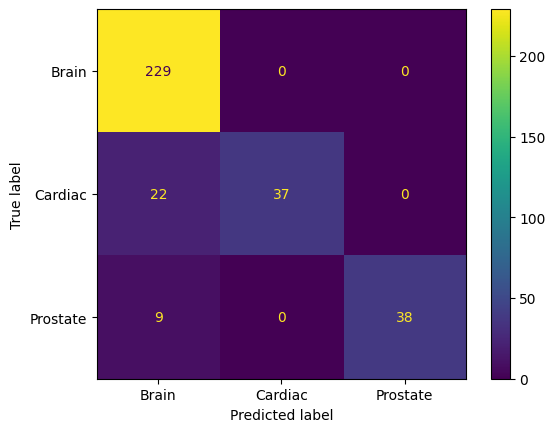

In [9]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

In [10]:
err_df = dev.copy()[y_pred!=y_dev]
err_df["pred"] = y_pred[y_pred!=y_dev]

Cardiac errors

In [11]:
dev[y_pred!=y_dev]

,title,doi,abstract,task
578,A reciprocal learning strategy for semisupervi...,10.1002/mp.15923,semisupervised strategy has been utilized to a...,Cardiac
900,Domain generalization of deep networks for med...,10.1016/b978-0-32-399851-2.00016-8,the generalization capacity of deep models is ...,Prostate
532,Semi-Supervised Medical Image Segmentation Gui...,10.3390/bioengineering10020225,medical image processing tasks represented by ...,Cardiac
235,Multi-Scale Squeeze U-SegNet with Multi Global...,10.3390/s21103363,in this paper we propose a multiscale feature ...,Cardiac
960,Survey of Supervised Learning for Medical Imag...,10.1007/s42979-022-01166-1,medical image interpretation is an essential t...,Prostate
820,MRI pulse sequence integration for deep‐learni...,10.1002/mp.15136,magnetic resonance mr imaging is an essential ...,Prostate
912,CASF-Net: Cross-attention and cross-scale fusi...,10.1016/j.cmpb.2022.107307,automatic segmentation of medical images has p...,Prostate
179,Big data y nuevas tecnologías de la informació...,10.1016/j.recesp.2020.06.017,resumen la continua progresion tecnologica que...,Cardiac
826,Attention-Assisted Adversarial Model for Cereb...,10.1109/tmi.2022.3186731,cerebrovascular segmentation in timeofflight m...,Prostate
434,Deep learning model-based segmentation of medi...,10.1109/tencon54134.2021.9707278,medical image segmentation is quite challengin...,Cardiac


In [12]:
err_df[dev["task"] == "Cardiac"]

/tmp/ipykernel_55523/357293626.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err_df[dev["task"] == "Cardiac"]


,title,doi,abstract,task,pred
578,A reciprocal learning strategy for semisupervi...,10.1002/mp.15923,semisupervised strategy has been utilized to a...,Cardiac,Brain
532,Semi-Supervised Medical Image Segmentation Gui...,10.3390/bioengineering10020225,medical image processing tasks represented by ...,Cardiac,Brain
235,Multi-Scale Squeeze U-SegNet with Multi Global...,10.3390/s21103363,in this paper we propose a multiscale feature ...,Cardiac,Brain
179,Big data y nuevas tecnologías de la informació...,10.1016/j.recesp.2020.06.017,resumen la continua progresion tecnologica que...,Cardiac,Brain
434,Deep learning model-based segmentation of medi...,10.1109/tencon54134.2021.9707278,medical image segmentation is quite challengin...,Cardiac,Brain
220,Harnessing Big Data to Advance Treatment and U...,10.1161/circresaha.121.319969,pulmonary hypertension is a complex disease wi...,Cardiac,Brain
59,Conditional generative adversarial network for...,10.1002/mrm.27772,subject motion in mri remains an unsolved prob...,Cardiac,Brain
473,A Review on the Detection of the Post COVID-19...,10.1088/1742-6596/2327/1/012073,abstract long term diseases require continuous...,Cardiac,Brain
191,Positional Contrastive Learning for Volumetric...,10.1007/978-3-030-87196-3_21,the success of deep learning heavily depends o...,Cardiac,Brain
954,Improving Data-Efficiency and Robustness of Me...,10.3390/bioengineering10020207,we systematically evaluate the training method...,Cardiac,Brain


Prostate errors

In [13]:
err_df[dev["task"] == "Prostate"]

/tmp/ipykernel_55523/2283434052.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err_df[dev["task"] == "Prostate"]


,title,doi,abstract,task,pred
900,Domain generalization of deep networks for med...,10.1016/b978-0-32-399851-2.00016-8,the generalization capacity of deep models is ...,Prostate,Brain
960,Survey of Supervised Learning for Medical Imag...,10.1007/s42979-022-01166-1,medical image interpretation is an essential t...,Prostate,Brain
820,MRI pulse sequence integration for deep‐learni...,10.1002/mp.15136,magnetic resonance mr imaging is an essential ...,Prostate,Brain
912,CASF-Net: Cross-attention and cross-scale fusi...,10.1016/j.cmpb.2022.107307,automatic segmentation of medical images has p...,Prostate,Brain
826,Attention-Assisted Adversarial Model for Cereb...,10.1109/tmi.2022.3186731,cerebrovascular segmentation in timeofflight m...,Prostate,Brain
844,Versatile Convolutional Networks Applied to Co...,10.1007/s10916-021-01751-6,medical image segmentation has seen positive d...,Prostate,Brain
845,Morphable Convolutional Neural Network for Bio...,10.23919/date51398.2021.9474153,we propose a morphable convolution framework w...,Prostate,Brain
739,Automated stroke lesion segmentation in non-co...,10.1088/1361-6560/aba166,stroke lesion volume is a key radiologic measu...,Prostate,Brain
875,A Study on Using Deep Learning for Segmentatio...,10.1007/978-981-16-1550-4_14,segmentation of medical images using deep lear...,Prostate,Brain


Brain errors:

In [14]:
err_df[dev["task"] == "Brain"]

/tmp/ipykernel_55523/1383969162.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err_df[dev["task"] == "Brain"]


,title,doi,abstract,task,pred


Remark: better results but still some confusion especially with the Brain class. Maybe because it's the majority class or because of problems in the dataset

## One class classification with the same representation using one-class svm

In [15]:
from sklearn.svm import OneClassSVM

x_train_cardiac = vectorizer.transform(train[train["task"] == "Cardiac"]["abstract"].to_list())
x_train_brain = vectorizer.transform(train[train["task"] == "Brain"]["abstract"].to_list())
x_train_prostate = vectorizer.transform(train[train["task"] == "Prostate"]["abstract"].to_list())

x_dev_cardiac = vectorizer.transform(dev[dev["task"] == "Cardiac"]["abstract"].to_list())
x_dev_brain = vectorizer.transform(dev[dev["task"] == "Brain"]["abstract"].to_list())
x_dev_prostate = vectorizer.transform(dev[dev["task"] == "Prostate"]["abstract"].to_list())

for nu in [0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.5]:
    print(f"\n=====================Nu: {nu}=====================")
    svm = OneClassSVM(nu=nu)
    print('Model for brain classification')
    svm.fit(x_train_brain)
    pred = svm.predict(x_dev_brain)
    print("Detection of brain task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of ourlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for cardiac classification')
    svm.fit(x_train_cardiac)
    pred = svm.predict(x_train_cardiac)
    print("Detection of cardiac task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_prostate)
    print("Detection of outlier with prostate",sum(pred==-1)/len(pred)*100)

    print('\nModel for prostate classification')
    svm.fit(x_train_prostate)
    pred = svm.predict(x_train_prostate)
    print("Detection of prostate task",sum(pred==1)/len(pred)*100)

    pred = svm.predict(x_dev_cardiac)
    print("Detection of outlier with cardiac",sum(pred==-1)/len(pred)*100)

    pred = svm.predict(x_dev_brain)
    print("Detection of outlier with brain",sum(pred==-1)/len(pred)*100)



=====================Nu: 0.05=====================
Model for brain classification
Detection of brain task 89.95633187772926
Detection of ourlier with cardiac 25.423728813559322
Detection of outlier with prostate 48.93617021276596

Model for cardiac classification
Detection of cardiac task 87.02127659574468
Detection of outlier with brain 72.92576419213974
Detection of outlier with prostate 70.2127659574468

Model for prostate classification
Detection of prostate task 84.05797101449275
Detection of outlier with cardiac 54.23728813559322
Detection of outlier with brain 74.67248908296943

=====================Nu: 0.1=====================
Model for brain classification
Detection of brain task 83.4061135371179
Detection of ourlier with cardiac 32.20338983050847
Detection of outlier with prostate 55.319148936170215

Model for cardiac classification
Detection of cardiac task 87.65957446808511
Detection of outlier with brain 74.67248908296943
Detection of outlier with prostate 72.340425531914